In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import permutations
from tqdm import tqdm

In [ ]:
IMG_FOLDER = './dataset'
N_IMAGES = 1000
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# this cell was done by chatgpt

def load_data(n_images, img_folder):
    images = []
    results = []
    for i in range(1, n_images + 1):
        img = plt.imread(os.path.join(img_folder, f'{i}.png')).astype(np.float32)
        if img.ndim == 3:
            img = img.mean(axis=2)
        if img.max() <= 1.0:
            img = img * 255.0
        img = img[None, :, :]
        images.append(img)
        
        res = np.loadtxt(os.path.join(img_folder, f'{i}.txt')).astype(np.float32)
        results.append(res[None, :, :])
        
    images = np.stack(images)
    results = np.stack(results)
    
    print(images.min(), images.max(), results.min(), results.max())
    return torch.from_numpy(images), torch.from_numpy(results)

In [4]:
images, results = load_data(N_IMAGES, IMG_FOLDER)
images, results = images.to(DEVICE), results.to(DEVICE)

0.0 255.0 -345.64453 494.97656


In [5]:
class Filter(nn.Module):
    def __init__(self, weight=None):
        super().__init__()
        if weight == None:
            self.weight = nn.Parameter(torch.rand(1, 1, 3, 3))
        else:
            self.weight = weight

    def forward(self, x):
        return nn.functional.conv2d(x, self.weight, padding=1)

In [6]:
filter_A = Filter(weight=torch.tensor([[[[-1, -0.5, 0], [-0.5, 0.5, 0.5], [0, 0.5, 1]]]], dtype=torch.float32, device=DEVICE)).to(DEVICE)
filter_B = Filter(weight=torch.tensor([[[[0.0625, 0.0625, 0.0625], [0.0625, 0.0625, 0.0625], [0.0625, 0.0625, 0.0625]]]], dtype=torch.float32, device=DEVICE)).to(DEVICE)

all_permutations = list(permutations(['A', 'B', 'U']))

In [9]:
def experiment(order, images, targets, epochs, lr=1e-3):
    filter_U = Filter().to(DEVICE)
    optimizer = optim.Adam(filter_U.parameters(), lr=lr)
    loss_func = nn.MSELoss()
    losses = []

    tested_perm = {'A': filter_A, 'B': filter_B, 'U': filter_U}

    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        x = images
        for label in order:
            filt = tested_perm[label]
            x = filt(x)
        loss = loss_func(x, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    return filter_U.weight.detach().cpu().numpy(), losses

Тестируемый порядок: ('A', 'B', 'U')


100%|██████████| 3000/3000 [00:10<00:00, 296.50it/s]


Тестируемый порядок: ('A', 'U', 'B')


100%|██████████| 3000/3000 [00:14<00:00, 211.31it/s]


Тестируемый порядок: ('B', 'A', 'U')


100%|██████████| 3000/3000 [00:09<00:00, 317.79it/s]


Тестируемый порядок: ('B', 'U', 'A')


100%|██████████| 3000/3000 [00:14<00:00, 211.84it/s]


Тестируемый порядок: ('U', 'A', 'B')


100%|██████████| 3000/3000 [00:18<00:00, 158.57it/s]


Тестируемый порядок: ('U', 'B', 'A')


100%|██████████| 3000/3000 [00:18<00:00, 158.56it/s]


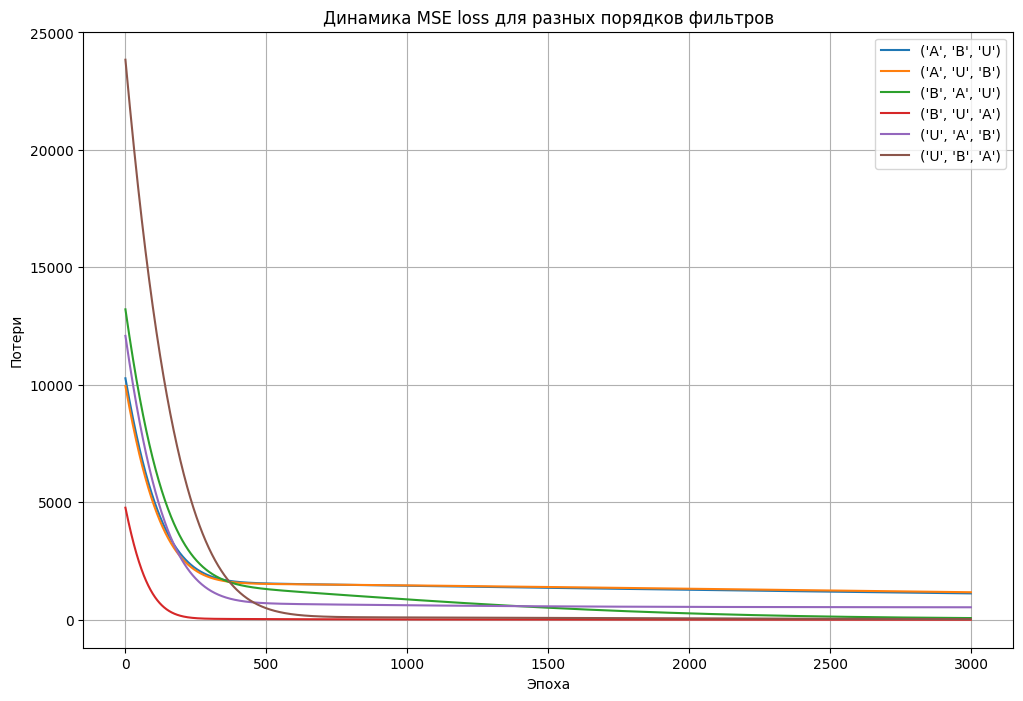

In [10]:
trial_all_results = []
trial_all_histories = {}

for order in all_permutations:
    print(f"Тестируемый порядок: {order}")
    weight, losses = experiment(order, images, results, epochs=3000)
    trial_all_histories[order] = losses
    trial_all_results.append((order, losses[-1]))

trial_all_results.sort(key=lambda x: x[1])

plt.figure(figsize=(12, 8))
for order, lhist in trial_all_histories.items():
    plt.plot(np.arange(len(lhist)), lhist, label=str(order))
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Динамика MSE loss для разных порядков фильтров')
plt.legend()
plt.grid()
plt.show()

In [11]:
best_loss = float('inf')
best_order = None
best_weight = None
all_histories = {}

best_order = [trial_all_results[0][0]]

for order in best_order:
    print(f"Тестируемый порядок: {order}")
    weight, losses = experiment(order, images, results, epochs=25000)
    all_histories[order] = losses
    if losses[-1] < best_loss:
        best_loss = losses[-1]
        best_order = order
        best_weight = weight

print('----- Лучший результат -----')
print('Порядок:', best_order)
print('Полученная матрица:\n', best_weight[0,0])

Тестируемый порядок: ('B', 'U', 'A')


100%|██████████| 25000/25000 [01:58<00:00, 211.64it/s]

----- Лучший результат -----
Порядок: ('B', 'U', 'A')
Полученная матрица:
 [[0.12500279 0.24999538 0.12500226]
 [0.24999532 0.5000092  0.24999543]
 [0.1250023  0.2499954  0.12500276]]
